# 文本预处理
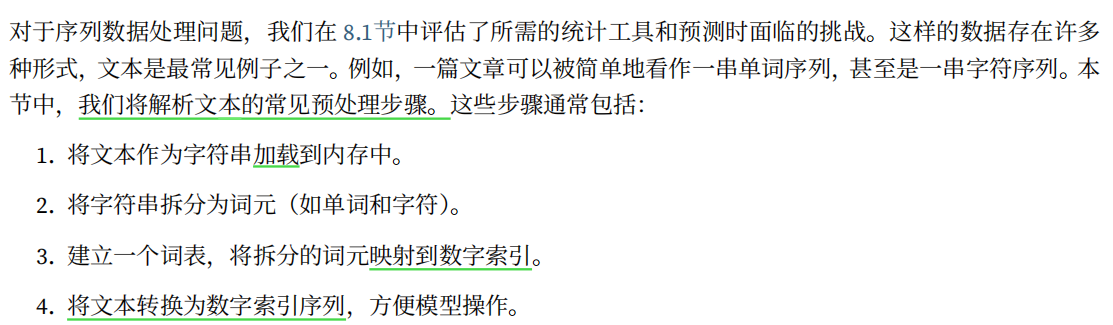

In [1]:
import collections
import re
from d2l import torch as d2l

## 读取数据集
忽略标点符号和字母大写

In [2]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', 
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数： {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数： 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 词元化
下面的tokenize函数将文本行列表（lines）作为输入，列表中的每个元素是一个文本序列（如一条文本行）。
每个文本序列又被拆分成一个词元列表，词元（token）是文本的基本单位。最后，返回一个由词元列表组成的列表，其中每个词元都是一个字符串（string）。

In [3]:
def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)
    
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 词表
构建一个字典，通常也叫词表，用来将字符串类型的词元映射到从0开始的数字索引中。我们现将训练集中的所有文档合并在一起，对它们的唯一词元进行统计，得到的统计结果称之为语料。然后根据每个唯一词元的出现频率，将其分配给一个数字索引。很少出现的词元通常被移除。这可以降低复杂性。另外，语料库中不存在或已经被删除的任何词元都将映射到一个特定的未知词元“\<unk\>”。我们可以选择增加一个列表，用于保存那些被保留的词元，例如：填充词元（“\<pad\>”）；序列开始词元（“\<bos\>”）；序列结束词元（“\<eos\>”）。

In [5]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens=[]
        if reserved_tokens is None:
            reserved_tokens = []
        
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key = lambda x: x[1],
                                    reverse = True)
        
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {
            token:idx
            for idx, token in enumerate(self.idx_to_token)
        }
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_token(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[idx] for index in indices]

    @property
    def unk(self): # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或者2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

我们首先使用时光机器数据集作为语料库来 **[构建词表]**，然后打印前几个高频词元及其索引。

In [6]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


现在，将 **每一条文本行转换成一个数字索引列表**。

In [7]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


## 整合所有功能

将所有功能打包到`load_corpus_time_machine`函数中

In [8]:
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或是一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 小结
* 文本是序列数据的一种最常见的形式之一。
* 为了对文本进行预处理，我们通常将文本拆分为词元，构建词表将词元字符映射为数字索引，并将文本数据转换为词元索引以供模型操作。